### Imports

In [76]:
from main import QuantumIR
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit
import numpy as np

### Generate the IR

In [77]:
# Run
quantum_ir = QuantumIR()
quantum_ir.run_dataclass()
quantum_ir.run_generate_ir()
quantum_ir.run_transformations()


IR:

builtin.module {
  "quantum.func"() ({
  ^0(%q0_0 : i1, %q1_0 : i1, %q2_0 : i1, %q3_0 : i1):
    %q4_0 = "quantum.init"() {"type" = i1, "value" = false} : () -> i1
    %q4_1 = "quantum.cnot"(%q0_0, %q4_0) : (i1, i1) -> i1
    %q4_2 = "quantum.cnot"(%q1_0, %q4_1) : (i1, i1) -> i1
    %q5_0 = "quantum.init"() {"type" = i1, "value" = false} : () -> i1
    %q5_1 = "quantum.ccnot"(%q2_0, %q3_0, %q5_0) : (i1, i1, i1) -> i1
    %q5_2 = "quantum.not"(%q5_1) : (i1) -> i1
    %q5_3 = "quantum.cnot"(%q4_2, %q5_2) : (i1, i1) -> i1
    %q5_4 = "quantum.cnot"(%q1_0, %q5_3) : (i1, i1) -> i1
    %q5_5 = "quantum.not"(%q5_4) : (i1) -> i1
    %q6_0 = "quantum.init"() {"type" = i1, "value" = false} : () -> i1
    %q7_0 = "quantum.init"() {"type" = i1, "value" = false} : () -> i1
    %q7_1 = "quantum.cnot"(%q0_0, %q7_0) : (i1, i1) -> i1
    %q7_2 = "quantum.cnot"(%q1_0, %q7_1) : (i1, i1) -> i1
    %q6_1 = "quantum.ccnot"(%q2_0, %q7_2, %q6_0) : (i1, i1, i1) -> i1
    %q5_6 = "quantum.measure"(%q5_5) 

### Transform CCNOT gates

In [78]:
quantum_ir.metrics_transformation()
quantum_ir.run_transformations()



CCNOT decomposition:

builtin.module {
  "quantum.func"() ({
  ^0(%q0_0 : i1, %q1_0 : i1, %q2_0 : i1, %q3_0 : i1):
    %q0_1 = "quantum.cnot"(%q1_0, %q0_0) : (i1, i1) -> i1
    %q4_0 = "quantum.init"() {"type" = i1, "value" = false} : () -> i1
    %q4_1 = "quantum.h"(%q4_0) : (i1) -> i1
    %q4_2 = "quantum.cnot"(%q3_0, %q4_1) : (i1, i1) -> i1
    %q4_3 = "quantum.tdagger"(%q4_2) : (i1) -> i1
    %q4_4 = "quantum.cnot"(%q2_0, %q4_3) : (i1, i1) -> i1
    %q4_5 = "quantum.t"(%q4_4) : (i1) -> i1
    %q4_6 = "quantum.cnot"(%q3_0, %q4_5) : (i1, i1) -> i1
    %q4_7 = "quantum.tdagger"(%q4_6) : (i1) -> i1
    %q4_8 = "quantum.cnot"(%q2_0, %q4_7) : (i1, i1) -> i1
    %q3_1 = "quantum.cnot"(%q2_0, %q3_0) : (i1, i1) -> i1
    %q3_2 = "quantum.tdagger"(%q3_1) : (i1) -> i1
    %q3_3 = "quantum.cnot"(%q2_0, %q3_2) : (i1, i1) -> i1
    %q2_1 = "quantum.t"(%q2_0) : (i1) -> i1
    %q3_4 = "quantum.t"(%q3_3) : (i1) -> i1
    %q4_9 = "quantum.t"(%q4_8) : (i1) -> i1
    %q4_10 = "quantum.h"(%q4_9) : (i

### Find input and output number

In [80]:
module = quantum_ir.module
funcOp = module.body.block._first_op

# Numbers and type of the input parameters
input_args = funcOp.body.block._args
input_number = input_args.__len__()
input_types = [arg.type for arg in input_args]

# First and last op
first_op = funcOp.body.block._first_op
last_op = funcOp.body.block._last_op
output_number = 0

current = first_op
while(current is not None):
    if current.name == "quantum.init":
        input_number += 1
    if current.name == "quantum.measure":
        output_number += 1
    current = current.next_op

print("Number of inputs: ", input_number, "Number of outputs: ", output_number)

Number of inputs:  6 Number of outputs:  2


### Initialize circuit

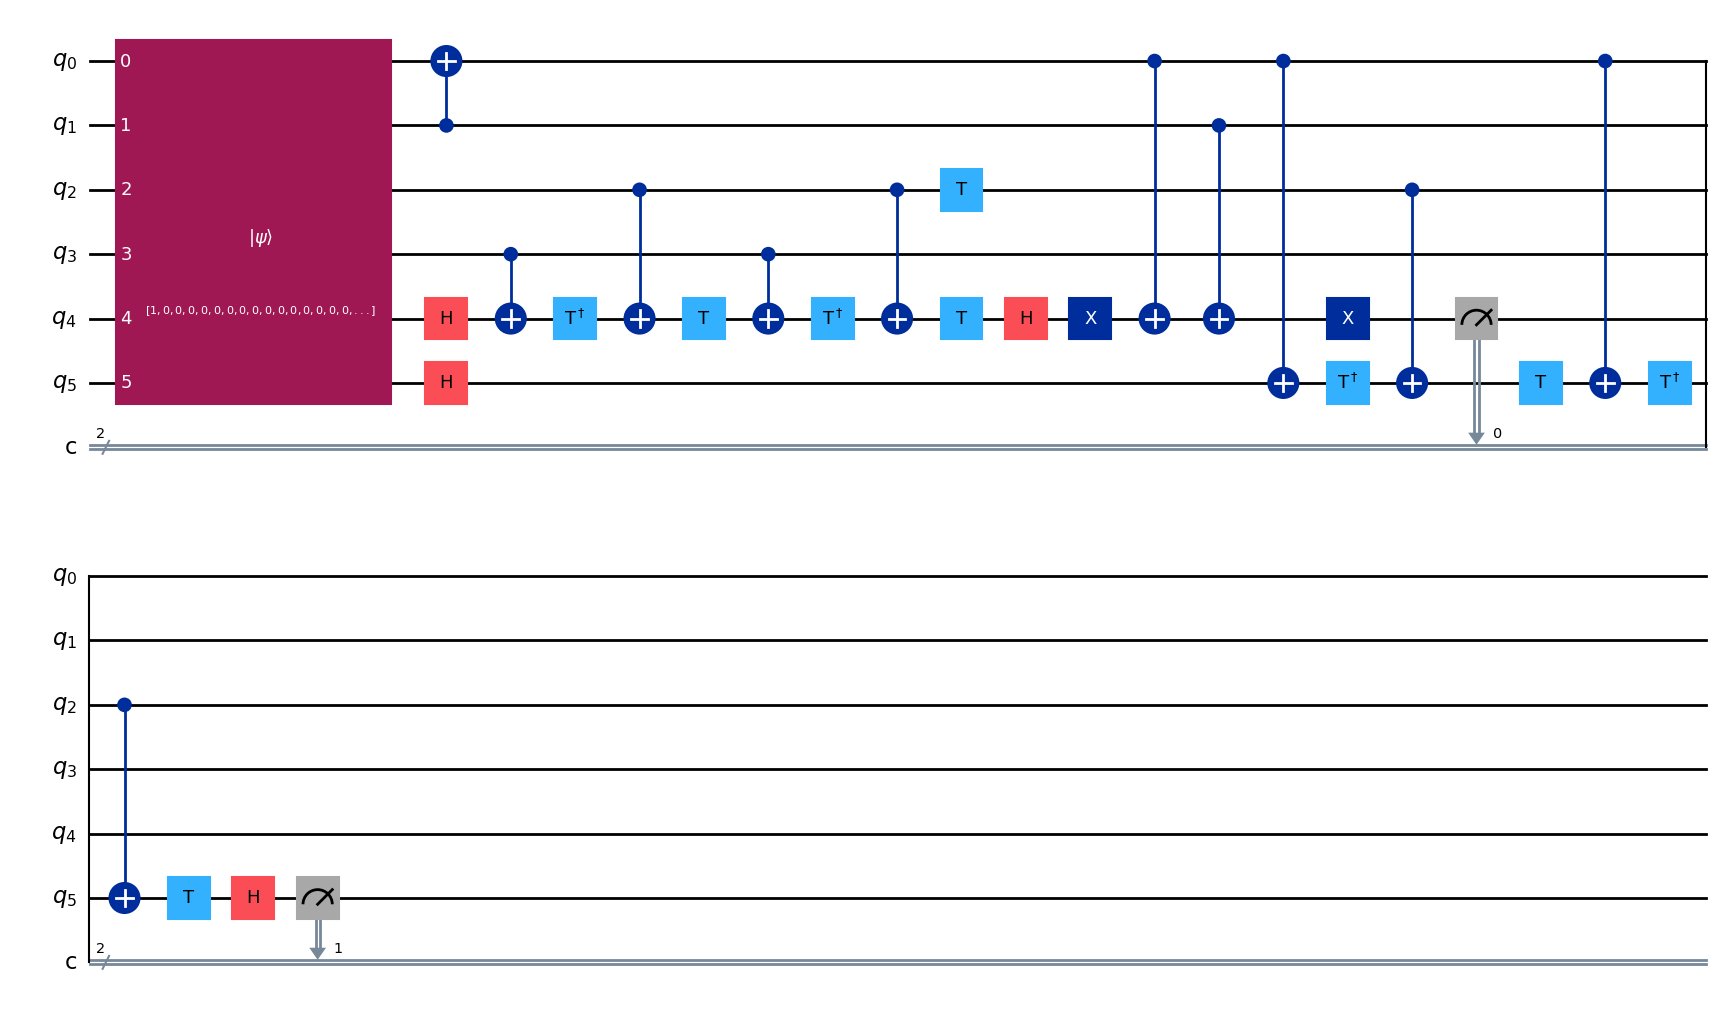

In [81]:

def create_circuit(first_op, input_number, output_number, state):

    circuit = QuantumCircuit(input_number, output_number)
    current = first_op
    cbit_index = 0

    qubit_list = [i for i in range(input_number)]

    circuit.initialize(state, qubit_list)

    while(current is not None):
        # find the indexes of the qubit
        operands_names = [op._name for op in current.operands]
        indexes = [int(name.split("_")[0][1]) for name in operands_names]
        if current.name == "quantum.not":
            circuit.x(indexes[0])
        if current.name  == "quantum.cnot":
            circuit.cx(indexes[0], indexes[1])
        if current.name == "quantum.ccnot":
            circuit.ccx(indexes[0], indexes[1], indexes[2])
        if current.name == "quantum.h":
            circuit.h(indexes[0])
        if current.name == "quantum.t":
            circuit.t(indexes[0])
        if current.name == "quantum.tdagger":
            circuit.tdg(indexes[0])
        if current.name == "quantum.measure":
            circuit.measure(indexes[0], cbit_index)
            cbit_index += 1
        
        current = current.next_op
    
    return circuit

# initializing it to an example state (e.g. all qubit at 0)
example_state = np.array([1] + [0] * (2**input_number - 1))
create_circuit(first_op, input_number, output_number,example_state).draw(output='mpl')



### Truth tables

In [82]:
from numpy import eye

istates = eye(2**input_number)

def bit_strings_iterative(N):
    bit_list = ['']
    for _ in range(N):
        bit_list = ['0' + bit_string for bit_string in bit_list] + \
                   ['1' + bit_string for bit_string in bit_list]
    return bit_list

# tutte le stringhe di bit di input_number bit
istr = bit_strings_iterative(input_number)

print(istr)
print(istates)

['000000', '000001', '000010', '000011', '000100', '000101', '000110', '000111', '001000', '001001', '001010', '001011', '001100', '001101', '001110', '001111', '010000', '010001', '010010', '010011', '010100', '010101', '010110', '010111', '011000', '011001', '011010', '011011', '011100', '011101', '011110', '011111', '100000', '100001', '100010', '100011', '100100', '100101', '100110', '100111', '101000', '101001', '101010', '101011', '101100', '101101', '101110', '101111', '110000', '110001', '110010', '110011', '110100', '110101', '110110', '110111', '111000', '111001', '111010', '111011', '111100', '111101', '111110', '111111']
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [83]:
from qiskit.providers import JobStatus

counts = {}
quantum_truth_table = {}
backend = AerSimulator()
qubit_list = [i for i in range(input_number)]

for i in range(istates.shape[1]):
    circuit = create_circuit(first_op, input_number, output_number, istates[i])

    job = backend.run(circuit, shots=2000)
    result = job.result()

    # Consider only the entries where the support output qubits are set to zero.
    if istr[i][:output_number] == '0' * output_number:
        counts[istr[i][output_number:]] = result.get_counts()

for outer_key, inner_dict in counts.items():
    for inner_key, value in inner_dict.items():
        quantum_truth_table[outer_key] = inner_key

print(quantum_truth_table)


{'0000': '00', '0001': '01', '0010': '00', '0011': '01', '0100': '00', '0101': '11', '0110': '10', '0111': '01', '1000': '00', '1001': '01', '1010': '00', '1011': '01', '1100': '01', '1101': '10', '1110': '11', '1111': '00'}


Notice that, both for input and output qubits, the q[0] is the rightmost one (little endian).

In [84]:
import csv

# Initialize the dictionary
classical_truth_table = {}

# Read the CSV file
with open('truth-tables/xorInPlace.csv', 'r') as file:
    csv_reader = csv.DictReader(file)
    
    # Dynamically find "out" columns
    out_columns = [col for col in csv_reader.fieldnames if col.startswith('out')]
    
    for row in csv_reader:
        # Extract the values of "out" columns, reverse them, and join as a string
        flipped_value = ''.join(str(row[col]) for col in reversed(out_columns))
        classical_truth_table[row['Inputs']] = flipped_value

print(classical_truth_table)

{'0000': '00', '0001': '01', '0010': '00', '0011': '01', '0100': '00', '0101': '11', '0110': '10', '0111': '01', '1000': '00', '1001': '01', '1010': '00', '1011': '01', '1100': '01', '1101': '10', '1110': '11', '1111': '00'}


In [85]:
equal = quantum_truth_table == classical_truth_table

# Print the result
print("Are the truth tables equal?", equal)

if not equal:
    for key in quantum_truth_table:
        if quantum_truth_table[key] != classical_truth_table.get(key):
            print(f"Difference found at key {key}: new_counts has {quantum_truth_table[key]}, data_dict has {classical_truth_table.get(key)}")

Are the truth tables equal? True


# Metriche
numero di qubit, numero di gate, depth (percorso critico)

In [86]:
print("Number of qubits in the quantum circuit:", circuit.num_qubits)
print("Number of gates in the quantum circuit:", circuit.size())
print("Depth of the quantum circuit:", circuit.depth())
print("Width of the quantum circuit:", circuit.width())

print("Gate counts for the quantum circuit:", circuit.count_ops())

Number of qubits in the quantum circuit: 6
Number of gates in the quantum circuit: 29
Depth of the quantum circuit: 23
Width of the quantum circuit: 8
Gate counts for the quantum circuit: OrderedDict([('cx', 11), ('t', 5), ('h', 4), ('tdg', 4), ('x', 2), ('measure', 2), ('initialize', 1)])


In [87]:
from qiskit.converters import circuit_to_dag
from qiskit.dagcircuit.dagcircuit import DAGOpNode

# Step 1: Convert to a DAGCircuit
dag = circuit_to_dag(circuit)

# Step 2: Retrieve the critical path
# Each element in the critical path is a node in the DAG that contributes to this longest path
critical_path = dag.longest_path()
print("Critical Path:")
for node in critical_path:
    if isinstance(node, DAGOpNode): 
        qubit_indices = [circuit.qubits.index(q) for q in node.qargs] 
        print(f"{node.name} {tuple(qubit_indices)}")

Critical Path:
initialize (0, 1, 2, 3, 4, 5)
h (4,)
cx (3, 4)
tdg (4,)
cx (2, 4)
t (4,)
cx (3, 4)
tdg (4,)
cx (2, 4)
t (4,)
h (4,)
x (4,)
cx (0, 4)
cx (0, 5)
tdg (5,)
cx (2, 5)
t (5,)
cx (0, 5)
tdg (5,)
cx (2, 5)
t (5,)
h (5,)
measure (5,)
